# Minimum Dominating Set (MDS) Problem

The Minimum Dominating Set problem [[1]](#MDSWiki) is a classical NP-hard problem in computer science and graph theory. In this problem, we are given a graph, and we aim to find the smallest subset of vertices such that every node in the graph is either in the subset or is a neighbor of a node in the subset.

We represent the problem as a binary optimization problem.

### Variables:

- $x_i$ binary variables that represent whether a node $i$ is in the dominating set or not.

### Constraints:

- Every node $i$ is either in the dominating set or connected to a node in the dominating set:

  $\forall i \in V: x_i + \sum_{j \in N(i)} x_j \geq 1$

  Where $N(i)$ represents the neighbors of node $i$.

### Objective

- Minimize the size of the dominating set:

  $\sum_{i\in V}x_i$

# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
import networkx as nx
import pyomo.core as pyo


def mds(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    @model.Constraint(graph.nodes)
    def dominating_rule(model, idx):
        sum_of_neighbors = sum(model.x[neighbor] for neighbor in graph.neighbors(idx))
        return model.x[idx] + sum_of_neighbors >= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.minimize)

    return model

The model contains:

- Index set declarations (model.Nodes, model.Arcs).
- Binary variable declaration for each node (model.x) indicating whether that node is chosen for the set.
- Constraint rule – for each node, it must be a part of the chosen set or be neighbored by one.
- Objective rule – the sum of the variables equals the set size.

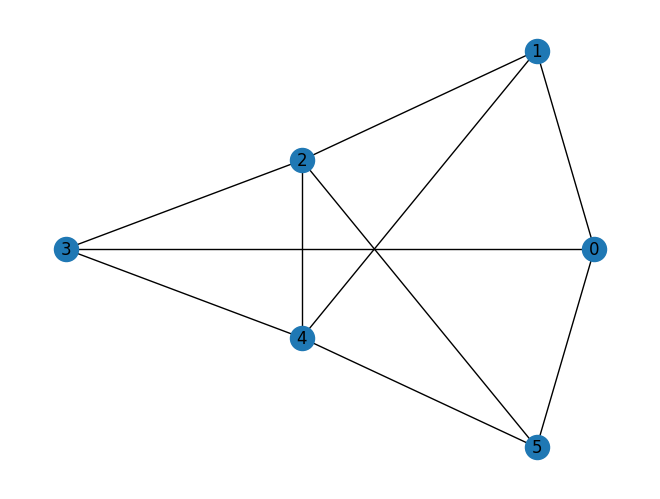

In [3]:
# generate a random graph
G = nx.erdos_renyi_graph(n=6, p=0.6, seed=8)
nx.draw_kamada_kawai(G, with_labels=True)

mds_model = mds(G)

In [4]:
mds_model.pprint()

2 Set Declarations
    dominating_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}

1 Var Declarations
    x : Size=6, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x[0] + x[1] + x[2] + x[3] + x[4] +

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=6, penalty_energy=8)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=30, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mds_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
from classiq import write_qmod

write_qmod(qmod, "minimum_dominating_set")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/85ac6043-0bed-4bf8-84a4-7e5d815bcb8d?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

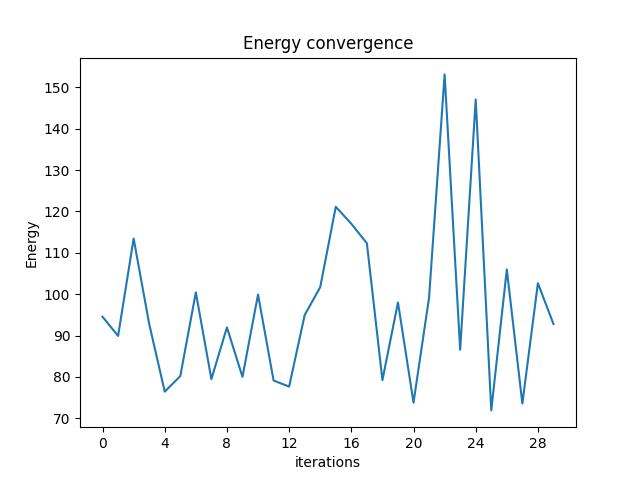

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mds_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
322,0.001,3.0,"[0, 0, 1, 0, 1, 1]",1
820,0.001,4.0,"[1, 1, 0, 0, 1, 1]",1
496,0.001,11.0,"[0, 0, 1, 1, 1, 0]",1
971,0.001,11.0,"[0, 1, 1, 0, 1, 0]",1
797,0.001,11.0,"[1, 1, 0, 0, 1, 0]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

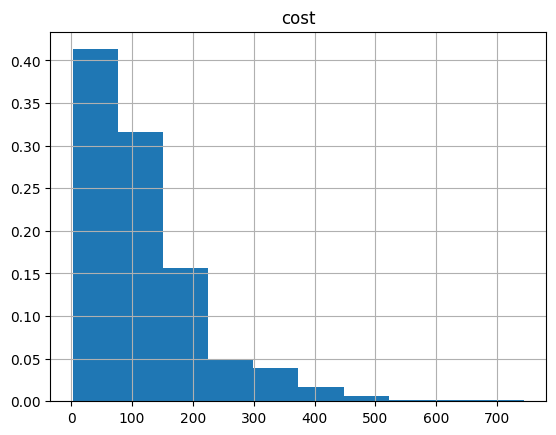

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

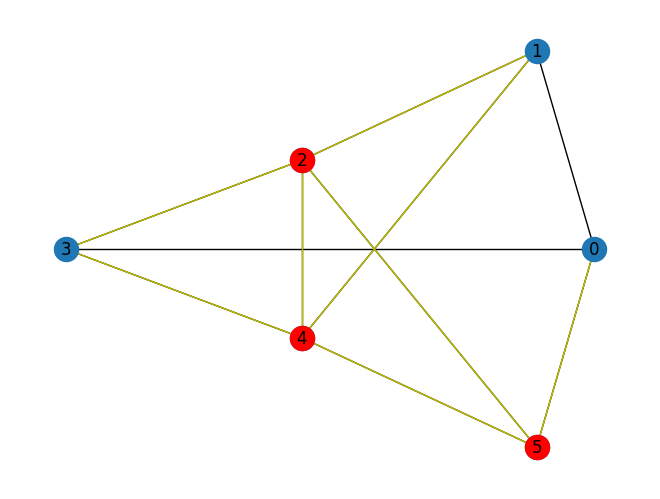

In [16]:
def draw_solution(graph: nx.Graph, solution: list):
    solution_nodes = [v for v in graph.nodes if solution[v]]
    solution_edges = [
        (u, v) for u, v in graph.edges if u in solution_nodes or v in solution_nodes
    ]
    nx.draw_kamada_kawai(graph, with_labels=True)
    nx.draw_kamada_kawai(
        graph,
        nodelist=solution_nodes,
        edgelist=solution_edges,
        node_color="r",
        edge_color="y",
    )


draw_solution(G, best_solution)

Lastly, we can compare to the classical solution of the problem:

In [17]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mds_model)

mds_model.display()
classical_solution = [int(pyo.value(mds_model.x[i])) for i in G.nodes]

Model unknown

  Variables:
    x : Size=6, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   2.0

  Constraints:
    dominating_rule : Size=6
        Key : Lower : Body : Upper
          0 :   1.0 :  2.0 :  None
          1 :   1.0 :  1.0 :  None
          2 :   1.0 :  1.0 :  None
          3 :   1.0 :  2.0 :  None
          4 :   1.0 :  1.0 :  None
          5 :   1.0 :  1.0 :  None


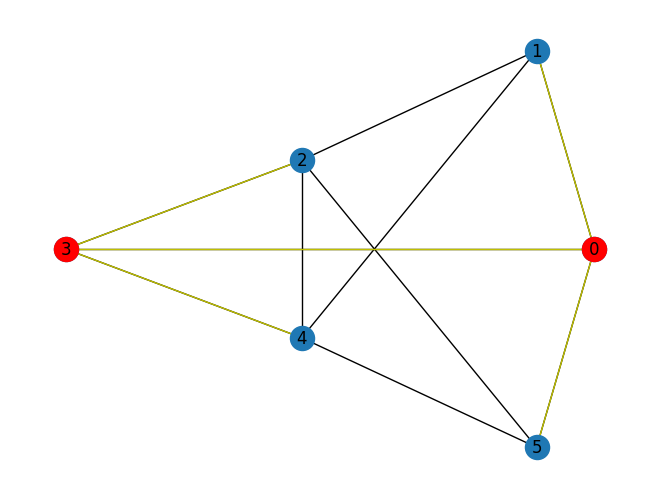

In [18]:
draw_solution(G, classical_solution)


## References

<a id='MDSWiki'>[1]</a>: [Dominating Set (Wikipedia)](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
